In [136]:
import pandas as pd
from ast import literal_eval
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.manifold import TSNE
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import parallel_coordinates

## 1. Load the Data

In [86]:
df = pd.read_csv("final_data_complete.csv")

In [87]:
df = df.drop(columns = ["FreebaseID", "Genres_tuples", "Languages_tuple", "Countries_tuples", "ActorGenderFlag", "movieId", "ActorGender", "merge_year"])
assert df["distilbert_emotions"].isna().sum() == df["Plot"].isna().sum()
df = df.dropna(subset = ["distilbert_emotions"])
df["distilbert_emotions"] = df["distilbert_emotions"].apply(literal_eval)


In [88]:
print (df["distilbert_emotions"][0].keys())

df["disgust"] = df["distilbert_emotions"].apply(lambda x: x["disgust"])
df["fear"] = df["distilbert_emotions"].apply(lambda x: x["fear"])
df["anger"] = df["distilbert_emotions"].apply(lambda x: x["anger"])
df["neutral"] = df["distilbert_emotions"].apply(lambda x: x["neutral"])
df["sadness"] = df["distilbert_emotions"].apply(lambda x: x["sadness"])
df["surprise"] = df["distilbert_emotions"].apply(lambda x: x["surprise"])
df["joy"] = df["distilbert_emotions"].apply(lambda x: x["joy"])
df_emotions = df[["disgust","fear","anger","neutral","sadness", "surprise","joy" ]]
#df_emotions = df_emotions.reset_index(drop=True)
print(df_emotions.head())

dict_keys(['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy'])
     disgust      fear     anger   neutral   sadness  surprise       joy
0   0.502122  0.351022  0.065147  0.057085  0.018771  0.004086  0.001766
3   0.324022  0.032032  0.502404  0.096385  0.037811  0.005438  0.001907
4   0.163747  0.002405  0.325650  0.440068  0.025255  0.005851  0.037024
12  0.021709  0.010488  0.006082  0.042634  0.915504  0.002163  0.001421
13  0.004746  0.003841  0.016094  0.679410  0.057925  0.129912  0.108072


# 2. Understand the data

## 2.1 Data distributions: Standardized vs. Unstandardized

In [89]:
df_emotions.describe()

,disgust,fear,anger,neutral,sadness,surprise,joy
count,33684.000000,33684.000000,33684.000000,33684.000000,33684.000000,33684.000000,33684.000000
mean,0.177764,0.149237,0.198539,0.219286,0.162752,0.046947,0.045474
std,0.214311,0.234104,0.229028,0.222535,0.233720,0.117281,0.123427
min,0.000178,0.000261,0.000586,0.000273,0.000860,0.000331,0.000223
25%,0.028759,0.008766,0.025399,0.051294,0.017766,0.004817,0.002622
50%,0.089153,0.033777,0.098616,0.131612,0.050893,0.010622,0.005704
75%,0.240457,0.177506,0.305622,0.321224,0.201197,0.029210,0.020456
max,0.987099,0.994397,0.990883,0.966400,0.988606,0.982970,0.983576


While emotions scores are on the same range they are on different scales -> standardize

In [90]:
standardizer = StandardScaler()
x_standardized = standardizer.fit_transform(df_emotions)
df_emotions_standardized= pd.DataFrame(x_standardized, columns = ["disgust","fear","anger","neutral","sadness", "surprise","joy" ])

Text(0.5, 1.0, 'Standardized')

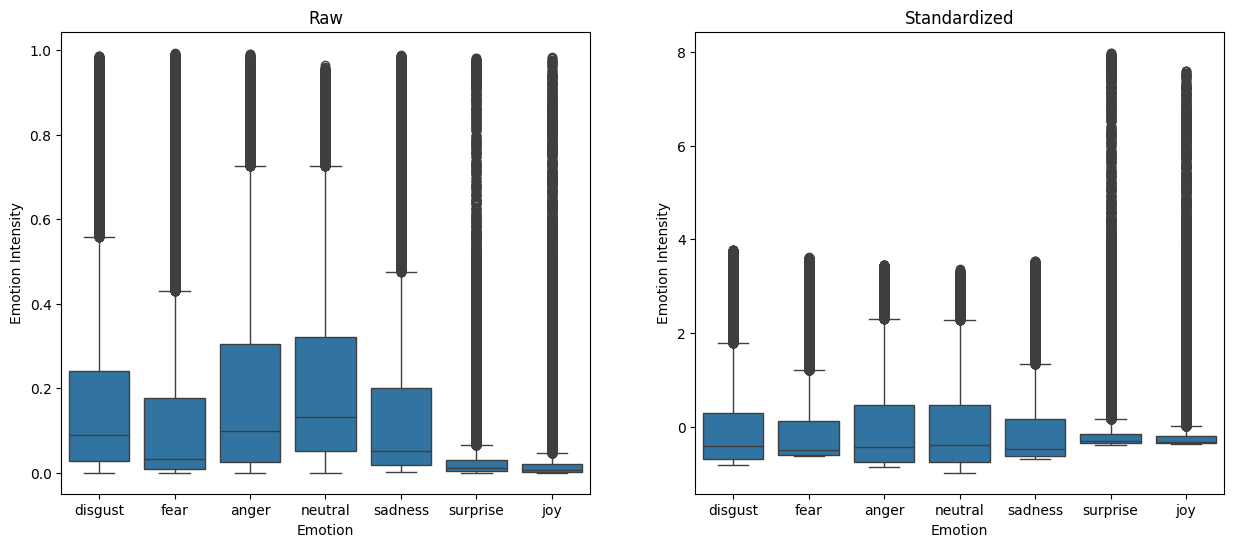

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6)) 
long_emotions = pd.melt(df_emotions, var_name='Emotion', value_name='Emotion Intensity')
long_emotions_standardized = pd.melt(df_emotions_standardized , var_name='Emotion', value_name='Emotion Intensity')
ax1= sns.boxplot(x="Emotion", y="Emotion Intensity", ax=axes[0], data=long_emotions)
ax1.set_title("Raw")
ax2 = sns.boxplot(x="Emotion", y="Emotion Intensity", ax=axes[1],data=long_emotions_standardized)
ax2.set_title("Standardized")

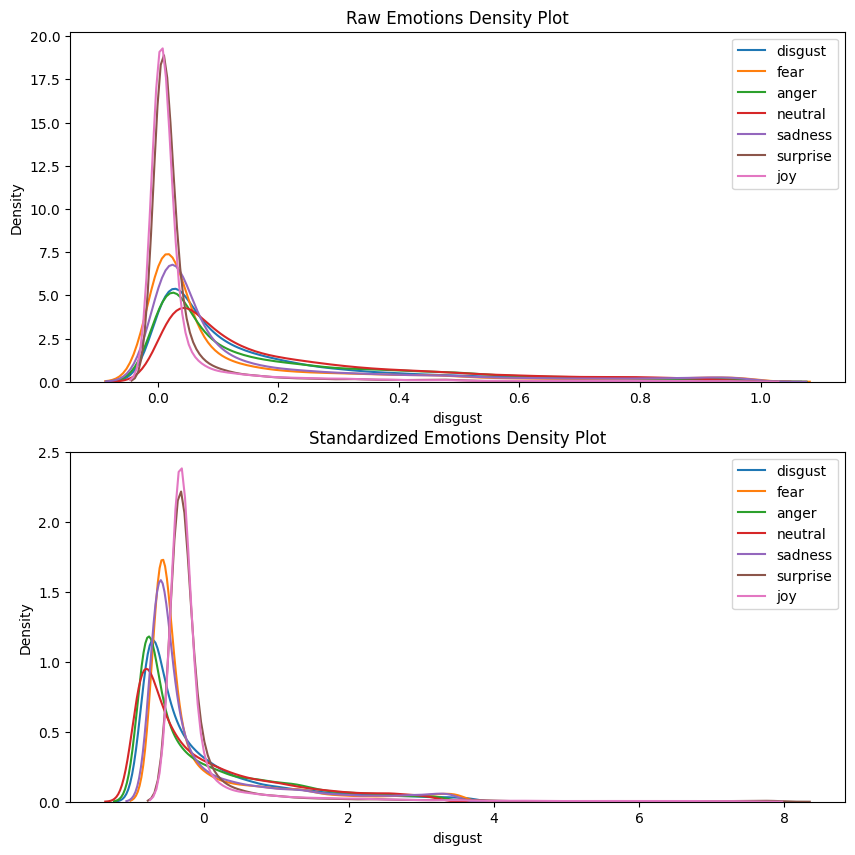

In [92]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10)) 
axes = axes.flatten()
for emotion in df_emotions.columns:
    ax1 = sns.kdeplot(data=df_emotions, x=emotion, ax=axes[0], label=emotion )
    ax1.set_title('Raw Emotions Density Plot')
    ax1.legend()
for emotion in df_emotions_standardized.columns:
    ax2 = sns.kdeplot(data=df_emotions_standardized, x=emotion, ax=axes[1], label=emotion )
    ax2.set_title('Standardized Emotions Density Plot')
    ax2.legend()

### Analysis with dimensionality reduction

### PCA
Measures linear relationship between data points. PCA leverages correlation between dimensions to retain as much variance as possible while projecting the features to a lower dimensional space.

In [93]:
pca = PCA(n_components=7)
pca.fit(x_standardized)


explained_variance_ratio = pca.explained_variance_ratio_
total_variance = sum(pca.explained_variance_ratio_)
print (total_variance)
print("Explained Variance Ratio per Principal Component: ", (explained_variance_ratio/total_variance) )

1.0
Explained Variance Ratio per Principal Component:  [2.19617464e-01 1.84789777e-01 1.74245101e-01 1.51494522e-01
 1.40970763e-01 1.28882372e-01 1.28609782e-15]


The results shows that all 7 principal components show significant variance, which is a sign for less correlation between dimensions. The visualization in 2d with the first two principal component only captures about 40% of the variance and therefore, might not be suitable for meassuring the clustering quality.

### t-nse
t-SNE (t-Distributed Stochastic Neighbor Embedding) is a non-linear technique for dimensionality reduction. Instead of capturing variance  t-SNE focuses on preserving the local structure of the data

### Compute Correlation

No high correlation between the emotions. Highest correlation value is about negative 0.3 between neutral and anger)

In [1]:
correlation_matrix = df_emotions_standardized.corr()
print(correlation_matrix)

NameError: name 'df_emotions_standardized' is not defined

### 2.2. Conclusion

Skwed data distributions

# 3. Clustering

## 3.1 K-Means Clustering

### 3.1.1 Finding the optimal number of clusters k

Text(0, 0.5, 'Silhouette score')

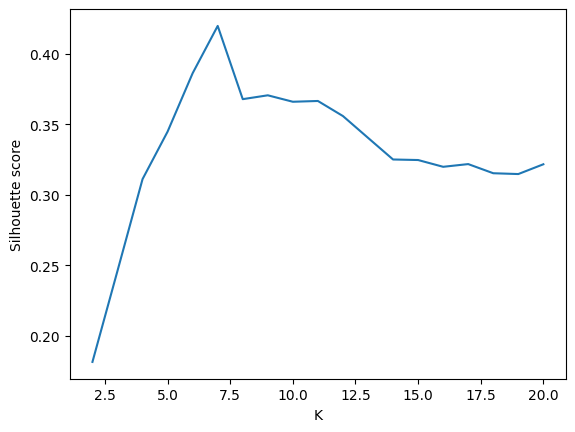

In [66]:
silhouettes = []

# Try multiple k
for k in range(2, 21):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(df_emotions_standardized)
    # Get the Silhouette score
    score = silhouette_score(df_emotions_standardized, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")

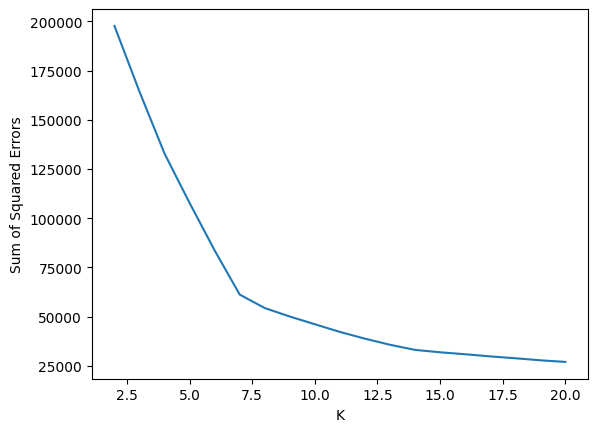

In [67]:
def plot_sse(df_emotions_standardized, start=2, end=21):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(df_emotions_standardized)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(df_emotions_standardized)

In [68]:
optimal_k = 7

### 3.1.2 Different cluster initializations to escape local optimums

The objective function of K-Means is to minimizing the within-cluster sum of squares (inertia). This is the metric it tries to minimize at each iteration. Therefore, initialization methods like k-means++' with n_init uses inertia to select the best initialization. We also loop over different random states and compare teh results to find the initialization with the lowest inertia

In [74]:
best_inertia = np.inf
best_sil_score = -1
best_random_state = None
best_labels = None

# We'll loop over, say, 10 different random states. You can increase this if desired.
for rs in range(50):
    km = KMeans(n_clusters=optimal_k, init='k-means++', random_state=rs, n_init=1)
    km.fit(df_emotions_standardized)
    labels = km.labels_
    inertia = km.inertia_
    sil = silhouette_score(df_emotions_standardized, labels)

    # Use a combination of metrics or prioritize one. 
    # Often, inertia is primary for KMeans initialization selection, 
    # but silhouette can also be considered.
    # Let's say we pick the run with the best (lowest) inertia, and if tie, best silhouette.
    if (inertia < best_inertia) or (inertia == best_inertia and sil > best_sil_score):
        best_inertia = inertia
        best_sil_score = sil
        best_random_state = rs
        best_labels = labels

print("Best run found with random_state:", best_random_state)
print("Best inertia:", best_inertia)
print("Best silhouette score:", best_sil_score)

Best run found with random_state: 31
Best inertia: 61240.475702318196
Best silhouette score: 0.41985879945898247


In [75]:
# Let KMeans do multiple initializations and pick the best
km = KMeans(
    n_clusters=optimal_k, 
    init='k-means++', 
    n_init=1000,      # number of initial centroid sets
    random_state=42 # ensures reproducibility
)
km.fit(df_emotions_standardized)

# The best run is now stored in km. 
# You have reproducible results and the best solution without manual looping.
labels = km.labels_
inertia = km.inertia_

print("Best inertia:", inertia)

Best inertia: 61240.47091337241


The result shows that k-means++' with n_init= 1000 finds a cluster with a within-cluster distance of 61240.47 which is better than the first 50 random states. The imporvements with an increasing number of n_init are maginal, as after n_init=10 the inertia is already at 61240. Therefore, we can asume that with the retrieved initialization we are near the global optimum in this setting with the k-means algorithm.

### 3.1.3 Visualization

### Visualization with PCA

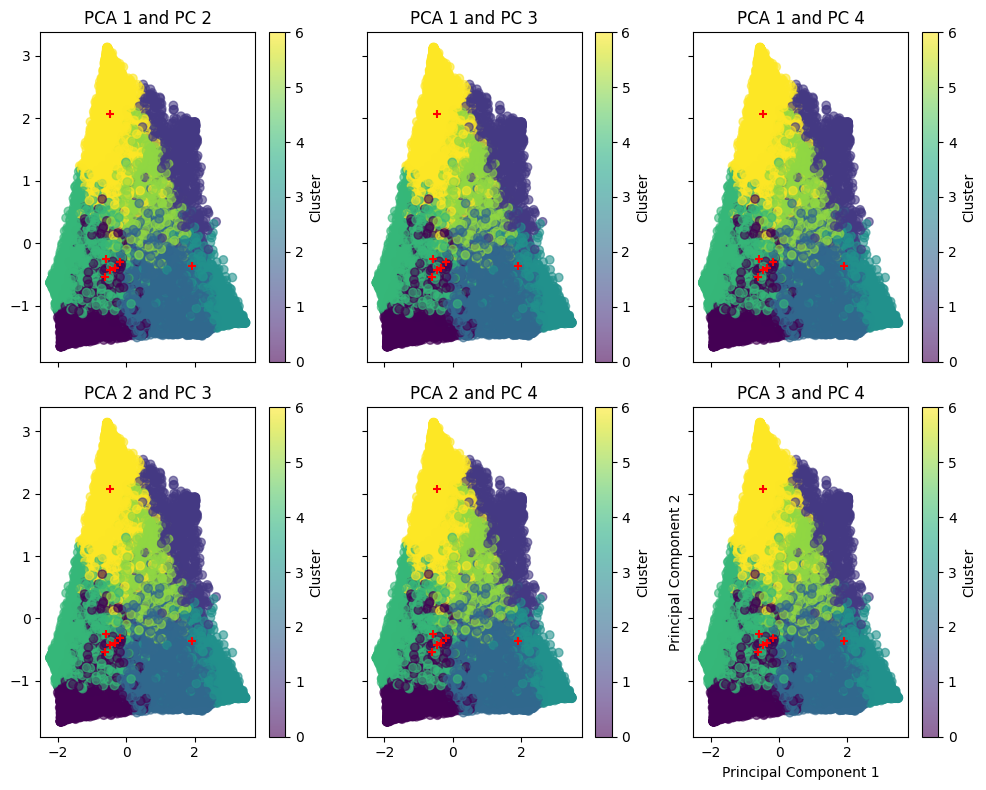

In [83]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(df_emotions_standardized)

COLUMNS = 3
ROWS = 2
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(10,8), sharey=True, sharex=True)
combinations = [[1, 2],[1, 3],[1, 4],[2, 3],[2, 4],[3, 4]]

for i, combination in enumerate(combinations):
    current_column = i % COLUMNS
    current_row = (i)//COLUMNS
    ax = axs[current_row, current_column]


    ax.scatter(X_pca[:,0], X_pca[:,1], c=km.labels_, alpha=0.6)
    ax.set_title(f"PCA {combination[0]} and PC {combination[1]}")
    plt.xlabel(f'Principal Component {combination[0]}')
    plt.ylabel(f'Principal Component {combination[1]}')
    cbar = plt.colorbar(ax.collections[0], ax=ax, label='Cluster')
    # Plot the centroids
    for c in km.cluster_centers_:
        ax.scatter(c[0], c[1], marker="+", color="red")

plt.tight_layout()

Even though, the clusters are mainly separated in the 2-dimensional PCA space (using the first 4 PC), the centroids of each clusters are mostly gathered around a point in space. 

### Visualizing with t-sne

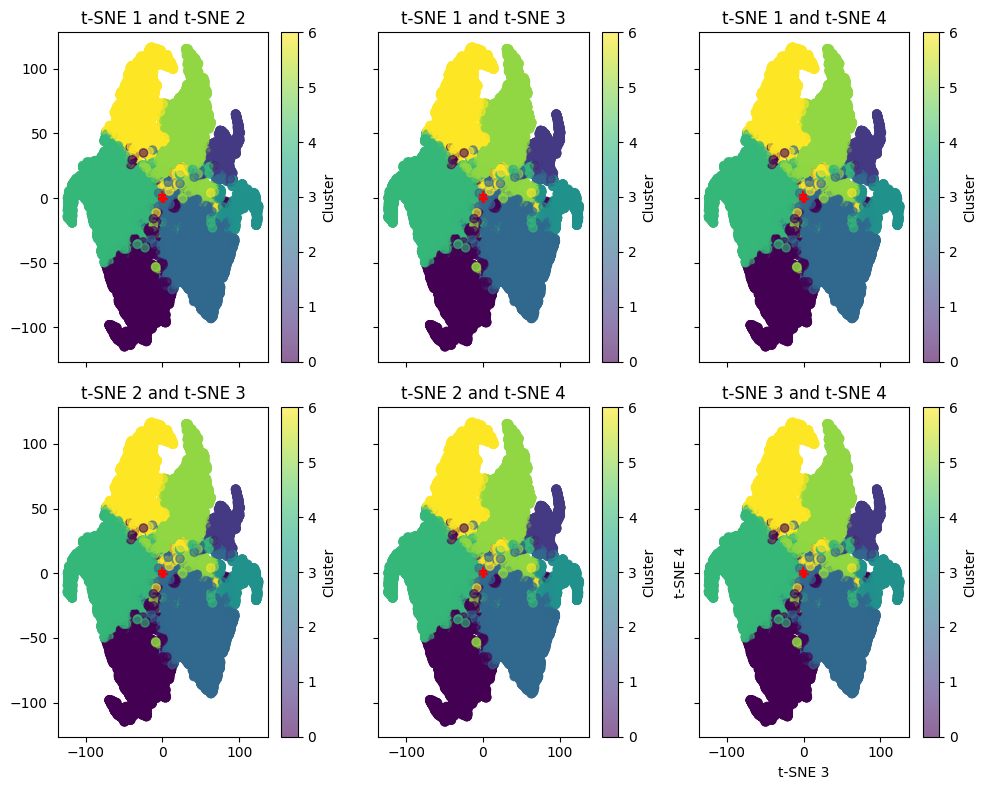

In [84]:
X_tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=10).fit_transform(df_emotions_standardized)

COLUMNS = 3
ROWS = 2
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(10,8), sharey=True, sharex=True)
combinations = [[1, 2],[1, 3],[1, 4],[2, 3],[2, 4],[3, 4]]

for i, combination in enumerate(combinations):
    current_column = i % COLUMNS
    current_row = (i)//COLUMNS
    ax = axs[current_row, current_column]


    ax.scatter(X_tsne[:,0], X_tsne[:,1], c=km.labels_, alpha=0.6)
    ax.set_title(f"t-SNE {combination[0]} and t-SNE {combination[1]}")
    plt.xlabel(f't-SNE {combination[0]}')
    plt.ylabel(f't-SNE {combination[1]}')
    cbar = plt.colorbar(ax.collections[0], ax=ax, label='Cluster')
    # Plot the centroids
    for c in km.cluster_centers_:
        ax.scatter(c[0], c[1], marker="+", color="red")

plt.tight_layout()

### 3.1.4 Calculating cluster based consumer ratings

### Calculating ratings for each cluster

In [143]:
df.head()
#mean_ratings	std_dev_ratings	count_ratings

len(df_emotions_standardized)
df_emotions.head()

df_cluster_catings = df_emotions.drop(columns = ["disgust","fear","anger","neutral","sadness", "surprise","joy"] )
df_cluster_emotions = df_emotions_standardized.copy()

df_cluster_emotions["cluster"] = km.labels_
df_cluster_emotions = df_cluster_emotions.groupby("cluster").mean().reset_index()

df_cluster_catings["cluster"] = km.labels_
df_cluster_catings["mean_ratings"] = df.loc[df_cluster_catings.index,"mean_ratings"]
df_cluster_catings["std_dev_ratings"]  = df.loc[df_cluster_catings.index,"std_dev_ratings"]
df_cluster_catings["count_ratings"]  = df.loc[df_cluster_catings.index,"count_ratings"]
print(f"Number of NaN values out of total:", df_cluster_catings["mean_ratings"].isna().sum(), "/", len(df_cluster_catings))

column_std = []
column_mean = []
for cluster in range(7):
    column_std.append(df_cluster_catings[df_cluster_catings["cluster"] == cluster]["mean_ratings"].std())
    column_mean.append(df_cluster_catings[df_cluster_catings["cluster"] == cluster]["mean_ratings"].mean())
    

#df_cluster_catings_grouped = df_cluster_catings.groupby("cluster").mean()
df_cluster_catings_grouped["std"] = column_std
df_cluster_catings_grouped["mean"] = column_mean

print(df_cluster_catings_grouped)
print(df_cluster_emotions)



Number of NaN values out of total: 24545 / 33684
         mean_ratings  std_dev_ratings  count_ratings       std      mean
cluster                                                                  
0            3.042202         0.940511      94.222222  0.845296  3.042202
1            3.085364         0.968767     177.907731  0.774683  3.085364
2            2.988571         0.973740     117.991629  0.799752  2.988571
3            3.082050         0.980701      94.197761  0.810154  3.082050
4            3.069220         0.954759     188.795176  0.767034  3.069220
5            3.159462         0.944724     128.549199  0.784386  3.159462
6            2.960432         0.959390     160.044501  0.821176  2.960432
   cluster   disgust      fear     anger   neutral   sadness  surprise  \
0        0  1.913978 -0.367155 -0.259950 -0.456993 -0.400536 -0.294237   
1        1 -0.581962 -0.245472 -0.483506 -0.397452 -0.359827  4.144890   
2        2 -0.342216 -0.386888 -0.468464  1.566253 -0.339363 -0

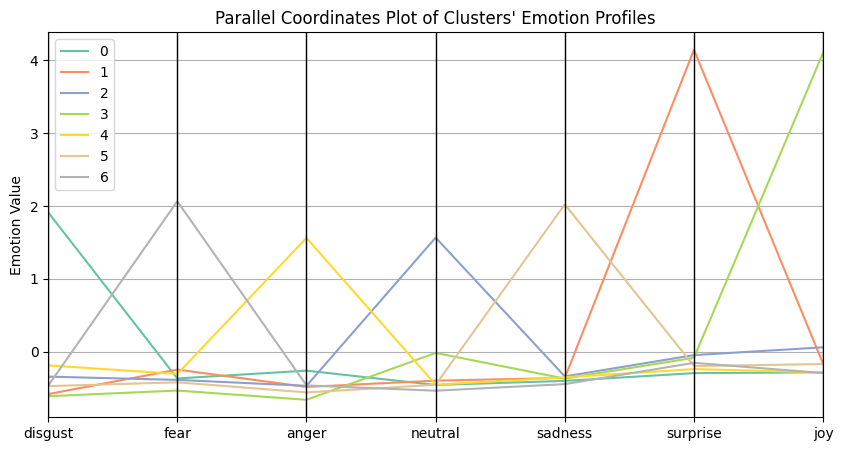

In [145]:
plt.figure(figsize=(10, 5))
parallel_coordinates(df_cluster_emotions, class_column='cluster', colormap=plt.get_cmap("Set2"))
plt.title("Parallel Coordinates Plot of Clusters' Emotion Profiles")
plt.ylabel("Emotion Value")
plt.legend()
plt.show()

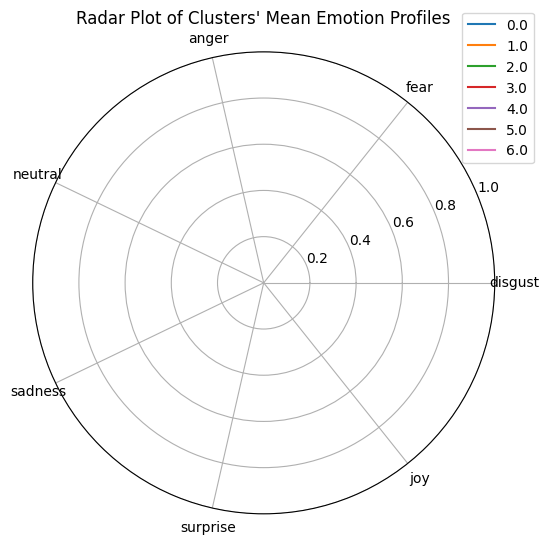

In [148]:
emotions_columns = [ "disgust","fear","anger","neutral","sadness", "surprise","joy"] 

# Number of variables
N = len(emotions_columns)

# Angles equally spaced around a circle
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)

# Prepare the plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each cluster on the radar
for i, row in df_cluster_emotions.iterrows():
    values = row[emotions_columns].values
    # Repeat the first value at the end to close the polygon
    values = np.concatenate([values, [values[0]]])
    # Also repeat the first angle
    angles_all = np.concatenate([angles, [angles[0]]])
    ax.plot(angles_all, values, label=row['cluster'])
    ax.fill(angles_all, values, alpha=0.1)  # fill area

# Add emotion labels at angles
ax.set_xticks(angles)
ax.set_xticklabels(emotions_columns)

# Set radial limits (optional)
ax.set_ylim(0, 1) # Adjust depending on your data range

ax.set_title("Radar Plot of Clusters' Mean Emotion Profiles")
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

## 3.2 Visualizing clusters

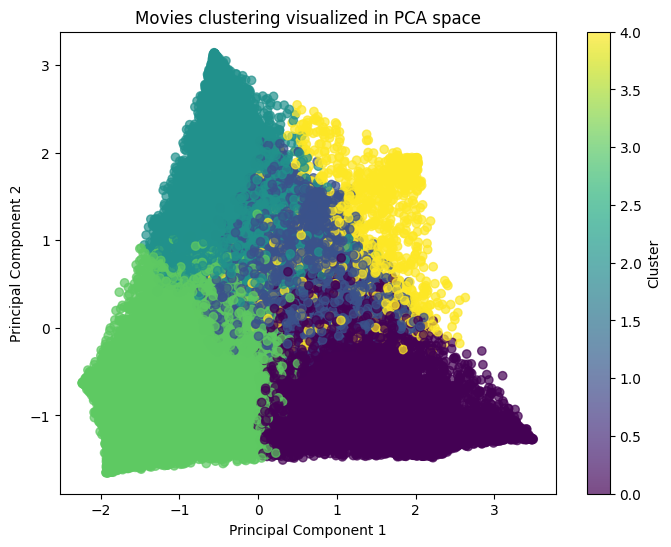

In [25]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_standardized)

# Plot the PCA components
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Movies clustering visualized in PCA space')
plt.colorbar(label='Cluster')
plt.show()


/Users/julian/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


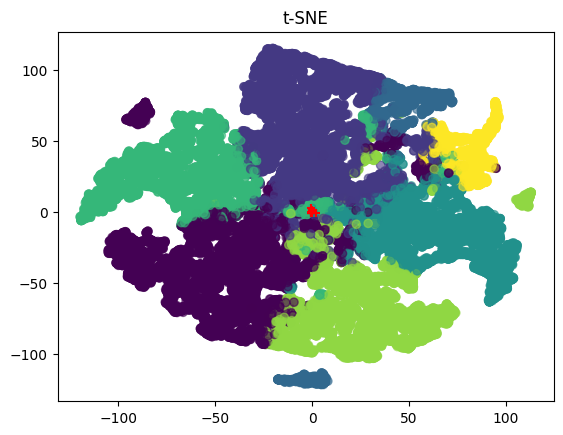

In [63]:
kmeans = KMeans(n_clusters=7, random_state=10).fit_predict(df_emotions_standardized)

X_reduced_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=10).fit_transform(df_emotions_standardized)
# Plot the data reduced in 2d space with t-SNE
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=kmeans, alpha=0.6)
plt.title("t-SNE")
for c in kmean.cluster_centers_:
        plt.scatter(c[0], c[1], marker="+", color="red")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

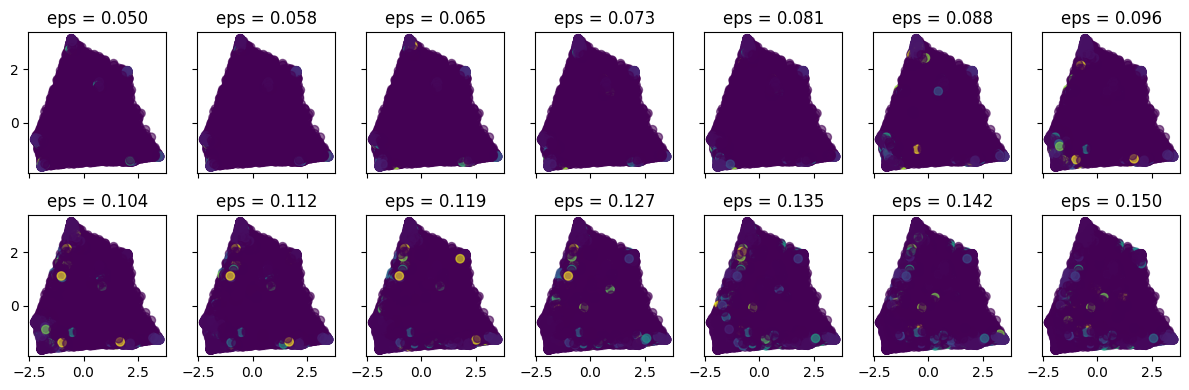

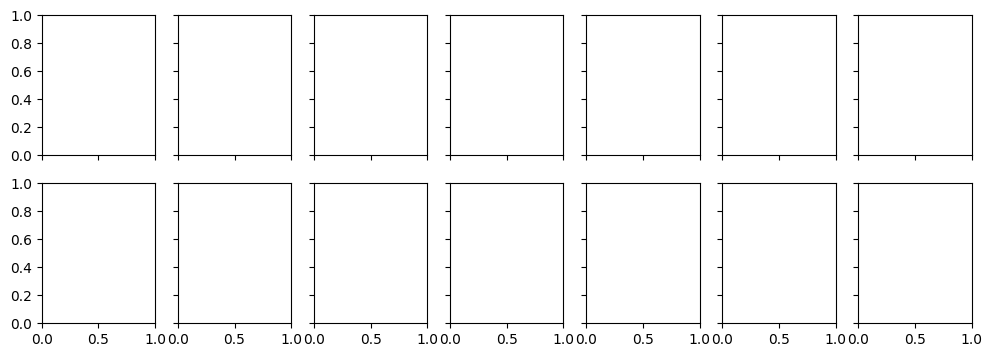

In [61]:
# Create a list of eps
eps_list = np.linspace(0.05, 0.15, 14)

# Compute number of row and columns
COLUMNS = 7
ROWS = math.ceil(len(eps_list)/COLUMNS)

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)

for i in range(0, len(eps_list)):
    eps = eps_list[i]
    
    current_column = i%COLUMNS
    current_row = i//COLUMNS
    
    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps).fit_predict(df_emotions_standardized)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(x_standardized)
    
    ax.scatter(X_pca[:,0], X_pca[:,1], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))
    
plt.tight_layout()

COLUMNS = 7
ROWS = math.ceil(len(eps_list)/COLUMNS)

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)

for i in range(0, len(eps_list)):
    eps = eps_list[i]
    
    current_column = i%COLUMNS
    current_row = i//COLUMNS
    
    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps).fit_predict(df_emotions_standardized)

    X_reduced_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=10).fit_transform(df_emotions_standardized)
    X_pca = pca.fit_transform(x_standardized)
    
    ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,0], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))
    
plt.tight_layout()


In [13]:
df.head()

,WikiID,Name,ReleaseDate,Runtime,Languages,Countries,Genres,Plot,nrclex_emotions,roberta_emotions,...,mean_ratings,std_dev_ratings,count_ratings,disgust,fear,anger,neutral,sadness,surprise,joy
0,975900,Ghosts of Mars,2001-08-24,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...","Set in the second half of the 22nd century, th...","{'fear': 0.16296296296296298, 'anger': 0.13333...","{'neutral': 0.8483592867851257, 'realization':...",...,2.427083,1.087064,144.0,0.502122,0.351022,0.065147,0.057085,0.018771,0.004086,0.001766
3,9363483,White Of The Eye,1987,110.0,['English Language'],['United Kingdom'],"['Thriller', 'Erotic thriller', 'Psychological...",A series of murders of rich young women throug...,"{'fear': 0.1751412429378531, 'anger': 0.135593...","{'neutral': 0.925209254026413, 'approval': 0.0...",...,2.250000,2.474874,2.0,0.324022,0.032032,0.502404,0.096385,0.037811,0.005438,0.001907
4,261236,A Woman in Flames,1983,106.0,['German Language'],['Germany'],['Drama'],"Eva, an upper class housewife, becomes frustra...","{'fear': 0.0673076923076923, 'anger': 0.105769...","{'neutral': 0.8632992506027222, 'approval': 0....",...,NaN,NaN,NaN,0.163747,0.002405,0.325650,0.440068,0.025255,0.005851,0.037024
12,6631279,Little city,1997-04-04,93.0,['English Language'],['United States of America'],"['Romantic comedy', 'Ensemble Film', 'Comedy-d...","Adam, a San Francisco-based artist who works a...","{'fear': 0.07317073170731707, 'anger': 0.04878...","{'neutral': 0.5400046110153198, 'sadness': 0.2...",...,NaN,NaN,NaN,0.021709,0.010488,0.006082,0.042634,0.915504,0.002163,0.001421
13,171005,Henry V,1989-11-08,137.0,['English Language'],['United Kingdom'],"['Costume drama', 'War film', 'Epic', 'Period ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...","{'neutral': 0.9365970492362976, 'approval': 0....",...,4.140052,0.835965,382.0,0.004746,0.003841,0.016094,0.679410,0.057925,0.129912,0.108072
